In [280]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [281]:
def encoders(f):
    words = f.read().splitlines()
    names = ''.join(words)
    vocab = sorted(list(set(names)))
    vocab = ['.'] + vocab
    vocab_size = len(vocab)
    stoi = {c: i for i, c in enumerate(vocab)}
    itos = {c: i for i, c in stoi.items()}

    return vocab, vocab_size, stoi, itos, words

def process(words,stoi):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0]*block_size
        for c in w+ '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

def data():
    with open('names.txt', 'r') as f:
        vocab, vocab_size, stoi, itos, words = encoders(f)
        n1 = int(len(words)*0.8)
        n2 = int(len(words)*0.9)
        xtrain, ytrain = process(words[:n1],stoi)
        xtest, ytest = process(words[n1:n2],stoi)
        xval, yval = process(words[n2:],stoi)

        print(f"xtrain and ytrain shape: {xtrain.shape}, {ytrain.shape}")
        print(f"xtest and ytest shape: {xtest.shape}, {ytest.shape}")
        print(f"xval and yval shape: {xval.shape}, {yval.shape}")
        return xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos

In [282]:
xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos = data()

xtrain and ytrain shape: torch.Size([182778, 3]), torch.Size([182778])
xtest and ytest shape: torch.Size([22633, 3]), torch.Size([22633])
xval and yval shape: torch.Size([22735, 3]), torch.Size([22735])


In [283]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        # set W and b to zero
        self.W = torch.zeros(fan_in, fan_out )
        self.b = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b != None:
            self.out += self.b
            return self.out
        else:
            return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b == None else [self.b])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        # params

        self.gamma = torch.zeros(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, unbiased=True, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt((xvar + self.eps))
        self.out = xhat * self.gamma + self.beta

        # update buffers
        if self.training:
            self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_emb = 10
n_hidden = 100

C = torch.randn(vocab_size, n_emb)
# layers = [Linear(n_emb*3, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#           Linear(n_hidden, vocab_size),
#           ]

layers = [Linear(n_emb*3, n_hidden),  Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, vocab_size),
          ]

with torch.no_grad():
    layers[-1].W *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

parameters = [param for layer in layers for param in layer.parameters()]
print(f"Number of parameters: {sum(param.nelement() for param in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of parameters: 46227


In [284]:
max_steps = 2000
batch_size = 32
lossi = []

stepi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, xtrain.shape[0], (batch_size,))
    xb, yb = xtrain[ix], ytrain[ix]

    emb = C[xb]
    x = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size

    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lossi.append(loss.item())
    lr = 1 if i < max_steps/2 else 0.01
    
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
    

    with torch.no_grad():
        ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])

    
    if i % (max_steps//5) == 0:
        print(f"Step {i}, Loss {loss.item()}")


Step 0, Loss 3.295837163925171
Step 400, Loss 2.7830491065979004
Step 800, Loss 2.9195713996887207
Step 1200, Loss 2.9010536670684814
Step 1600, Loss 2.68339467048645


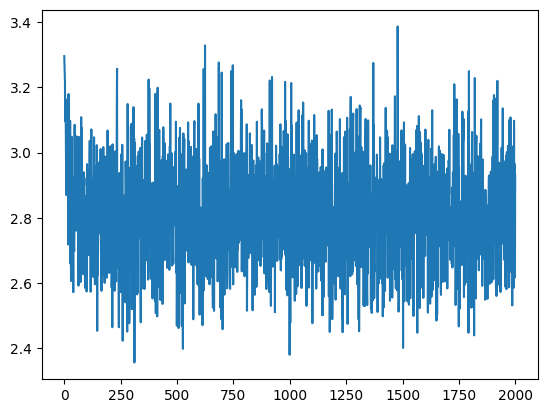

In [285]:
# We can see the model learns
plt.plot(lossi)

In [286]:
for i,p in enumerate(parameters):
    print(f"Param {i}, grad mean: {p.grad.mean().item()}, grad std: {p.grad.std().item()}")

Param 0, grad mean: 0.0, grad std: 0.0
Param 1, grad mean: 0.0, grad std: 0.0
Param 2, grad mean: 0.0, grad std: 0.0
Param 3, grad mean: 0.0, grad std: 0.0
Param 4, grad mean: 0.0, grad std: 0.0
Param 5, grad mean: 0.0, grad std: 0.0
Param 6, grad mean: 0.0, grad std: 0.0
Param 7, grad mean: 0.0, grad std: 0.0
Param 8, grad mean: 0.0, grad std: 0.0
Param 9, grad mean: 0.0, grad std: 0.0
Param 10, grad mean: 0.0, grad std: 0.0
Param 11, grad mean: 7.588554229442934e-10, grad std: 0.03516962379217148


In [287]:
# everything zero until the last layer
for i,l in enumerate(layers):
    t = l.out
    print(f'layer {i}: mean {t.mean()}, std {t.std()}, all zeros: {torch.all(torch.zeros(t.shape) == t)}')

    if i==10:
        print(torch.all(t == parameters[-1]))

layer 0: mean 0.0, std 0.0, all zeros: True
layer 1: mean 0.0, std 0.0, all zeros: True
layer 2: mean 0.0, std 0.0, all zeros: True
layer 3: mean 0.0, std 0.0, all zeros: True
layer 4: mean 0.0, std 0.0, all zeros: True
layer 5: mean 0.0, std 0.0, all zeros: True
layer 6: mean 0.0, std 0.0, all zeros: True
layer 7: mean 0.0, std 0.0, all zeros: True
layer 8: mean 0.0, std 0.0, all zeros: True
layer 9: mean 0.0, std 0.0, all zeros: True
layer 10: mean -9.33219723719958e-07, std 1.173477053642273, all zeros: False
tensor(False)


## Conclusion

In [288]:
# In the first iteration, the output of the model is zero
# as every weight and bias is zero. Loss.backward() sets gradient zero
# to every parameter except the last layer bias as it is the only one
# that contributes to the loss. With this, we can conclude that this last
# bias is the only parameter in the whole model that learns, making the
# model trash :P